# Определение возраста покупателей

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.shape

(7591, 2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7311a14f90>]],
      dtype=object)

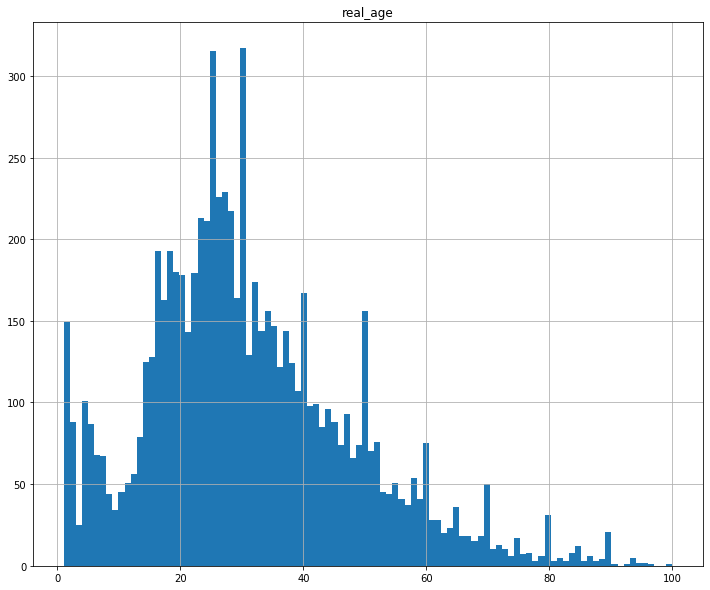

In [7]:
labels.hist(bins=100, figsize=(12,10))

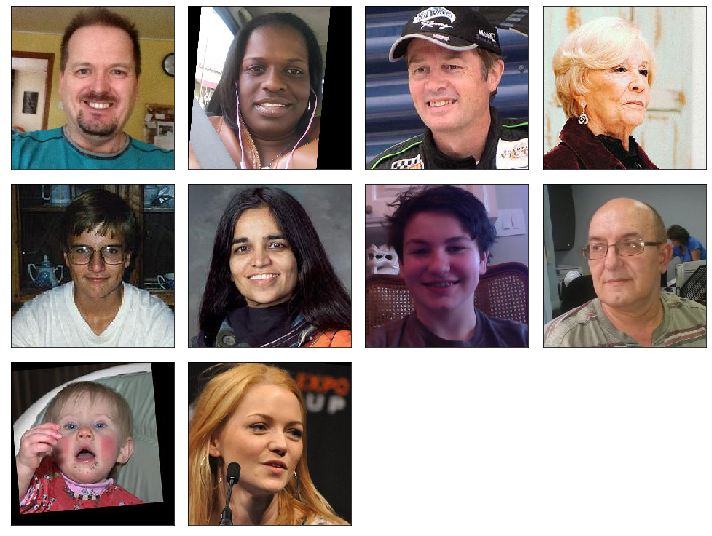

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод
В выборке 7591 фотографий, что не так много для обучения. Присутствуют фотографии усложняющие обучение (обрезанная голова, шапки, очки). Больше всего фотографий людей в возрасте от 23 до 30 лет. Также присутствуют фотографии очень юных людей от 2х лет

1) В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость

2) В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона

3) В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев

4) В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев

5) В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба

## Обучение модели

(Код в этом разделе запускается в отдельном GPU, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
OUT:

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-01-14 08:27:43.706270: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-14 08:27:46.375794: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 71s - loss: 205.2912 - mae: 10.3814 - val_loss: 400.7758 - val_mae: 15.0558
Epoch 2/10
356/356 - 38s - loss: 85.8137 - mae: 7.0396 - val_loss: 237.5866 - val_mae: 12.1473
Epoch 3/10
356/356 - 38s - loss: 59.5420 - mae: 5.8675 - val_loss: 96.0910 - val_mae: 7.3088
Epoch 4/10
356/356 - 38s - loss: 43.4280 - mae: 5.0402 - val_loss: 97.2749 - val_mae: 7.7221
Epoch 5/10
356/356 - 38s - loss: 30.9341 - mae: 4.2886 - val_loss: 71.9027 - val_mae: 6.3524
Epoch 6/10
356/356 - 38s - loss: 25.0148 - mae: 3.8363 - val_loss: 68.7036 - val_mae: 6.1669
Epoch 7/10
356/356 - 38s - loss: 20.6580 - mae: 3.4238 - val_loss: 67.7706 - val_mae: 6.1780
Epoch 8/10
356/356 - 38s - loss: 15.5707 - mae: 3.0151 - val_loss: 69.2597 - val_mae: 6.1450
Epoch 9/10
356/356 - 38s - loss: 13.7401 - mae: 2.8458 - val_loss: 74.8582 - val_mae: 6.4298
Epoch 10/10
356/356 - 38s - loss: 12.3863 - mae: 2.6670 - val_loss: 66.6709 - val_mae: 6.1211

```

При помощи архитектуры ResNet50, а также оптимизации Adam удалось достичь результат метрики MAE < 6.13 на тестовой выборке. Также была применена аугментация для увеличения тренировочной выборки.

## Анализ обученной модели

Достигнута достаточно хорошая точность предсказания. Абсолютная средняя ошибка = 6. В аналитике обычно не нужен конкретный возраст человека, куда важнее определить принадлежность к какой-то группе возрастов (диапазон 18-25, 26-32 и тп). Мне кажется, что MAE 6, которое у нас получилось допустимо при работе с возрастной группой от 35 лет и старше, там ошибка в 6 лет будет не такой критичной, как условно при определении возраста 3-х летнего ребенка по фотографии. Поэтому чтобы сеть работала хорошо со всеми возрастами лучше дополнительно поработать с обучением сети, а также увеличить обучающую выборку для получения более качественного результата.